# is it a bird? 

In [3]:
import socket,warnings 
try: 
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET,socket.SOCK_STREAM).connect(('1.1.1.1',53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [4]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai 'duckduckgo_search>=6.2'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.5/234.5 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 76.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 83.8 MB/s eta 0:00:00:00:01


In 2015 the idea of creating a computer system that could recognise birds was considered so outrageously challenging that it was the basis of [this XKCD joke](https://xkcd.com/1425/):

But today, we can do exactly that in just a few minutes, using entirely free resources!

The basic steps we'll take care of : 
1. Use DuckDuckGo to search for images "bird photos"
2. Use DuckDuckGo to search for images "forest photos"
3. Fine-Tune a pre-trained neural network to recognize these two groups
4. Try running this model on a picture of bird and forest to see whether it's recognizing correctly?
   

# Step 1: Download Images of Birds and Forest images

In [7]:
from duckduckgo_search import DDGS
from fastcore.all import * 
import time,json 
def search_images(keywords,max_images=200):
    return L(DDGS().images(keywords,max_results=max_images)).itemgot('image')

In [8]:
urls=search_images('birds photos',max_images=1)
urls[0]

'https://images.pexels.com/photos/326900/pexels-photo-326900.jpeg?cs=srgb&dl=wood-flight-bird-326900.jpg&fm=jpg'

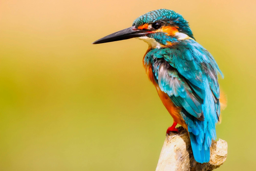

In [9]:
from fastdownload import download_url 
dest='bird.jpg'
download_url(urls[0],dest,show_progress=False)

from fastai.vision.all import * 
im=Image.open(dest)
im.to_thumb(256,256)

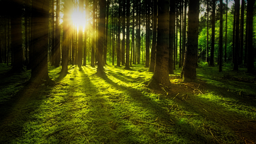

In [10]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

In [12]:
searches='forest','bird'
path=Path('bird_or_not')

for o in searches: 
    dest=(path/o)
    print(dest)
    dest.mkdir(exist_ok=True,parents=True)
    download_images(dest,urls=search_images(f'{o}photo'))
    time.sleep(5)
    resize_images(path/o,max_size=400,dest=path/o)

bird_or_not/forest
bird_or_not/bird


# Step 2: Train our Model 

some photos migth not be downloaded correctly which could cause our model training to fail, so we'll remove them 

In [13]:
failed= verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

8

to train a model, we'll need `DataLoaders`, which is an object that contains a training set (images used for training) and a validation set(used for testing the accuracy of model --not used for training). In fastai we can create that easily using a `DataBlock` and view sample images from it. 

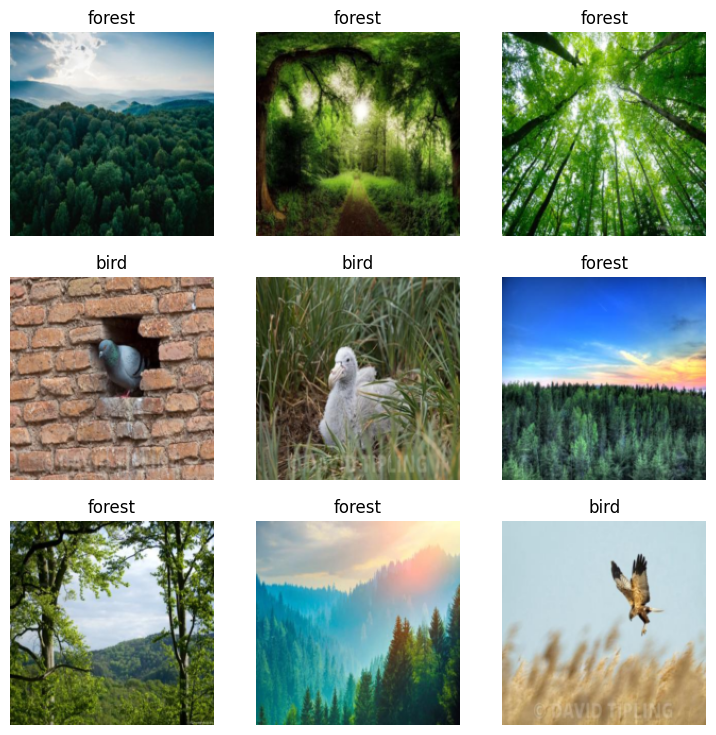

In [15]:
dls=DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2,seed=42),
    get_y=parent_label, 
    item_tfms=[Resize(192,method='squish')]
).dataloaders(path,bs=32)

dls.show_batch()

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [16]:
learn=vision_learner(dls,resnet18,metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 193MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.476591,0.181454,0.069444,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.074176,0.071545,0.027778,00:01
1,0.051632,0.081736,0.027778,00:01
2,0.036584,0.040268,0.013889,00:01


`Fine-Tuning` a model means that we are starting with a model with someoneelse model which is trained on other dataset. we'll be changing bits of the weights as training which can adapt to your `Dataset`, the model which is used is trained on a 1000 category of images called `ImageNet` 

# Step 3: Use our model to predict 

Let's see what our model thinks about the bird image which we've downloaded in the start 

In [17]:
is_bird,_,probs=learn.predict(PILImage.create('bird.jpg'))
print(f'the confidence of image as identified as {is_bird} is {probs[0]:.4f}')

the confidence of image as identified as bird is 0.9999
